# Value Estimation -- quadrature vs uniform

In [1]:
import math
from importlib import reload

import matplotlib.pyplot as plt
import pickle
import numpy as np

from tqdm.notebook import tqdm

from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time.environments import cartpole2
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

from pprint import pprint

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
cartpole2 = reload(cartpole2)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CartPole-OURS-v2 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Make this notebook configurable so we can quickly generate plots for multiple variants.

In [2]:
utils.set_directory_in_project()

Changed working directory to /Users/szepi1991/Code/adaptive_time


'/Users/szepi1991/Code/adaptive_time'

In [3]:
# Execute the notebook with arguments; from
# https://stackoverflow.com/a/48414195

import sys,os,argparse
from IPython.display import HTML
CONFIG_FILE = '.tmp_config_ipynb'
if os.path.isfile(CONFIG_FILE):
    with open(CONFIG_FILE) as f:
        sys.argv = f.read().split()
else:
    sys.argv = ['test_args.py', '--discrete_reward', 'True']
    # sys.argv = ['test_args.py', 'input_file', '--int_param', '12']


def str2bool(v):
    """From: https://stackoverflow.com/a/43357954 ."""
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')


parser = argparse.ArgumentParser()
parser.add_argument(
    "--generate_new_data", type=str2bool, nargs='?', default=False,
    help="If true, generate new trajectory data, else load from file.")
parser.add_argument(
    "--save_new_data", type=str2bool, nargs='?', default=True,
    help="If true, save the newly generated data a file.")

parser.add_argument(
    "--discrete_reward", type=str2bool, nargs='?', default=True,
    help="Use the step function reward.")
parser.add_argument(
    "--terminate_env", type=str2bool, nargs='?', default=False,
    help="Whether to terminate the environment when the pole falls.")


parser.add_argument(
    "--num_runs", type=int, default=30,
    help="The number of independent runs per method.")
parser.add_argument(
    "--sample_budget", type=int, default=1_000_000,
    help="The number of total samples accessible to all methods.")


# parser.add_argument("input_file",  help="Input image, directory, or npy.")
# parser.add_argument("--int_param", type=int, default=4, help="an optional integer parameter.")
args = parser.parse_args()

print(args.discrete_reward)


True


## Use goodish policy, generate data to process

Recall, we want:

1. The policy to stay up for ~10k steps, while we interact for 20k steps.
2. To generate trajectories from 100 different initial states.

We just need to store the fine grained rewards for each of these trajectories, all processing will happen on this after. 

In [4]:
# def _pid_sigmoid(x):
#     return 1.0 / (1.0 + np.exp(-x))

# class PidController:

#     def __init__(self):
#         self.desired_state = np.array([0, 0, 0, 0])
#         self.desired_mask = np.array([0, 0, 1, 0])

#         self.P = 0.1
#         self.D = 0.5
#         self.I = 0.0  # don't use integral

#         self.integral = 0 # we are not going to use intergral
#         self.prev_error = 0.0
#         self.derivative = 0.0

#     def control(self, state):
#         '''
#         Only uses the PD controller
#         '''
#         error = state - self.desired_state
#         self.integral += error
#         self.derivative = error - self.prev_error
#         self.prev_error = error
#         pid = np.dot(self.P * error  + self.D * self.derivative, self.desired_mask)

#         action = _pid_sigmoid(pid)
#         action = np.round(action).astype(np.int32)
#         return action
    

In [60]:

# GENERATE_NEW_DATA = False
# GENERATE_NEW_DATA = True
GENERATE_NEW_DATA = args.generate_new_data

# SAVE_TRAJECTORIES = False
# SAVE_TRAJECTORIES = True
SAVE_TRAJECTORIES = args.save_new_data

SHOULD_TERMINATE = args.terminate_env
# SHOULD_TERMINATE = False
# # SHOULD_TERMINATE = True

discrete_reward = args.discrete_reward
# # discrete_reward = False
# discrete_reward = True


# # SHOULD_TERMINATE = False
# SHOULD_TERMINATE = True
# # discrete_reward = False
# discrete_reward = True



In [61]:

if discrete_reward:
    reward_type = "discrete"
else:
    reward_type = "continuous"


BASE_DIR = f"results/cartpole2/rew_{reward_type}_term{SHOULD_TERMINATE}"
traj_data_file = f"many_good_trajs.pkl"



In [62]:
utils.set_directory_in_project(BASE_DIR, create_dirs=True)  # Just to make the dir.
utils.set_directory_in_project()
traj_data_path = os.path.join(BASE_DIR, traj_data_file)

if GENERATE_NEW_DATA:
    seed = 13
    dt_scaler = 100.
    new_dt = 0.02 / dt_scaler
    # new_dt = 0.0002
    # new_dt = 0.02
    STEPS_MAX = 20_000
    STEPS_BREAK_FROM = 9_000
    # STEPS_MAX = 50
    # STEPS_BREAK_FROM = 0
    # PROB_OF_BREAK = 0.001

    NUM_TRAJS = 100

    from adaptive_time import mc2
    import adaptive_time.utils
    import gymnasium as gym
    import random

    env = gym.make(
        'CartPole-OURS-v2',
        discrete_reward=discrete_reward,
        should_terminate=SHOULD_TERMINATE,
        step_time=new_dt)
    _NUM_ACTIONS = 2

    # pid_controller = PidController()
    phi = run_lib.make_features()

    weights_good_policy = np.load("cartpole_weights_20240227-102913_ret92516.44719752521.npy")
    # weights_good_policy = np.load("cartpole_weights_20240227-102913_ret50756.37604280466.npy")

    # def policy(state, num_step):
    #     """Is a good policy for the beginning, then switches to a bad one."""
    #     return pid_controller.control(state)
    #     # if num_step > STEPS_BREAK_FROM and random.random() < PROB_OF_BREAK:
    #     #     return env.action_space.sample()
    #     # else:
    #     #     return pid_controller.control(state)

    # implement epsilon-greedy action sampling. 
    def policy(state, num_step, weights, epsilon):
        """Returns the action to take, and maybe the prob of all actions"""
        # if num_step >= STEPS_BREAK_FROM:
        #     # Going to try to make failing and staying down likely.
        #     dir_ = None   # -1 for left, 1 for right
        #     outcome = random.random()
        #     if outcome < 0.8:
        #         # Strategy: if angle is close to 0, act to speed the pole up,
        #         #   if it is farther, act to slow it down.
        #         if abs(state[2]) < 0.1:
        #             dir_ = math.copysign(1, state[3])
        #         else:
        #             dir_ = math.copysign(1, -state[3])
        #     else:
        #         # Aim towards the center, but only if not too fast.
        #         dir_ = math.copysign(1, -(state[0]+state[1]*2))
        #     return int((dir_+1)/2)
        #     # outcome = random.random()
        #     # if outcome < 0.1:
        #     #     return 0
        #     # else:
        #     # # if outcome < 0.99:
        #     #     if state[1] < 0:
        #     #         return 1
        #     #     else:
        #     #         return 0
        if num_step >= STEPS_BREAK_FROM:
            # if random.random() < 0.52:
            if random.random() < 0.55:
                return 0   # Alway push in one direction.

        if random.random() < epsilon:
            action = env.action_space.sample()
            return action

        # Otherwise calculate the best action.
        x = phi.get_fourier_feature(state)
        qs = np.zeros(_NUM_ACTIONS)
        for action in range(_NUM_ACTIONS):
            x_sa = mc2.phi_sa(x, action)
            qs[action] = np.inner(x_sa.flatten(), weights)
        # adaptive_time.utils.softmax(qs, 1)
        
        return adaptive_time.utils.argmax(qs)

    run_lib.reset_randomness(seed, env)

    def _random_start_state(num):
        rand = np.random.standard_normal((num, 4))
        # rand *= np.array([[0.01, 0.01, 0.005, 0.002]])
        rand *= np.array([[0.01, 0.01, 0.005, 0.002]])
        return rand

    start_states = _random_start_state(NUM_TRAJS)
    print("shape", start_states.shape)
    print("max", np.max(start_states, axis=0))

    total_rewards = []
    reward_sequences = []
    traj_lengths = []
    angles = []
    xs = []
    d_angles = []
    actions = []
    dxs = []
    for idx in tqdm(range(NUM_TRAJS)):
        start_state = tuple(start_states[idx])
        # Tuple[float, float, float, float]
        trajectory, early_term = value_est.generate_trajectory(
                env, start_state=start_state,
                policy=lambda st, sn: policy(st, sn, weights_good_policy, 0.0),
                # policy=policy,
                termination_prob=0.0, max_steps=STEPS_MAX)

        traj_lengths.append(len(trajectory))
        rewards = [r for _, _, r, _ in trajectory]
        actions.append([a for _, a, _, _ in trajectory])
        xs.append([s[0] for s, _, _, _ in trajectory])
        angles.append([s[2] for s, _, _, _ in trajectory])
        d_angles.append([s[3] for s, _, _, _ in trajectory])
        dxs.append([s[1] for s, _, _, _ in trajectory])
        reward_sequences.append(rewards)
        total_rewards.append(sum(rewards))

    total_rewards = np.array(total_rewards)
    # Reward sequences may be different lengths in the terminating
    # case, so we can't make a 2D array.
    if not SHOULD_TERMINATE:
        reward_sequences = np.array(reward_sequences)
        traj_lengths = np.array(traj_lengths)
        angles = np.array(angles)
        xs = np.array(xs)
        d_angles = np.array(d_angles)
        actions = np.array(actions)
        dxs = np.array(dxs)

    if SAVE_TRAJECTORIES:
        all_traj_data = (
            total_rewards, reward_sequences, traj_lengths,
            angles, xs, d_angles, actions, dxs
        )
        with open(traj_data_path, "wb") as f:
            pickle.dump(all_traj_data, f)
        print("Saved data to", traj_data_path)

    print(env.tau)

else:
    with open(traj_data_path, "rb") as f:
        all_traj_data = pickle.load(f)
    (
        total_rewards, reward_sequences, traj_lengths,
        angles, xs, d_angles, actions, dxs
    ) = all_traj_data

    print("Loaded data from", traj_data_path)


print("total_rewards for each traj:", total_rewards)
if hasattr(reward_sequences, "shape"):
    print("all rewards shape if array:", reward_sequences.shape)
num_trajs = len(total_rewards)

Changed working directory to /Users/szepi1991/Code/adaptive_time/results/cartpole2/rew_discrete_termTrue
Changed working directory to /Users/szepi1991/Code/adaptive_time
shape (100, 4)
max [0.01849613 0.03401106 0.01296042 0.00477349]


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


Saved data to results/cartpole2/rew_discrete_termTrue/many_good_trajs.pkl
0.0002
total_rewards for each traj: [11597. 11193. 11203. 11486. 11103. 11442. 11150. 11212. 11059. 11378.
 11369. 11000. 11201. 11482. 11393. 11293. 11541. 11087. 11403. 10899.
 11379. 11298. 11472. 10939. 11353. 11676. 11428. 11762. 11219. 11306.
 11304. 11154. 11812. 11378. 11299. 11213. 11776. 11337. 11295. 11041.
 10946. 11633. 11174. 11033. 11903. 12073. 11194. 11186. 11139. 11224.
 11423. 11234. 11136. 11223. 11116. 11479. 11559. 11383. 11516. 11312.
 11205. 11026. 11261. 11201. 11109. 11448. 11246. 11681. 11018. 11601.
 11692. 11468. 11717. 11303. 11360. 11167. 11792. 10886. 11099. 11338.
 11614. 11413. 11639. 11210. 11259. 11500. 11287. 11451. 11386. 11821.
 11365. 11262. 11909. 11515. 11090. 11256. 11381. 11476. 11371. 11466.]


/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tau to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.tau` for environment variables or `env.get_wrapper_attr('tau')` that will search the reminding wrappers.
  logger.warn(


In [63]:
utils.set_directory_in_project(BASE_DIR, create_dirs=True)

Changed working directory to /Users/szepi1991/Code/adaptive_time/results/cartpole2/rew_discrete_termTrue


'/Users/szepi1991/Code/adaptive_time/results/cartpole2/rew_discrete_termTrue'

### Analyze trajectories

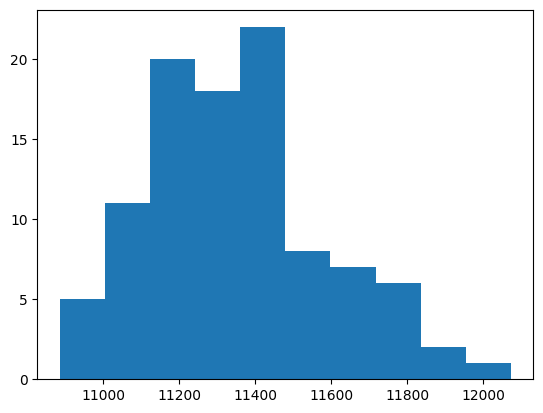

In [64]:
plt.hist(total_rewards)
plt.savefig('reward_total_distr.png')

11597.0


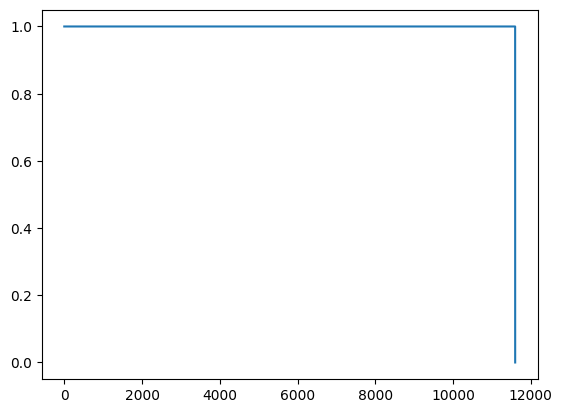

In [65]:
traj_idx = 0
print(total_rewards[traj_idx])
plt.plot(reward_sequences[traj_idx])
plt.savefig('reward_sample_curve.png')

### Deep Traj Analysis

Text(0.5, 1.0, 'Velocity')

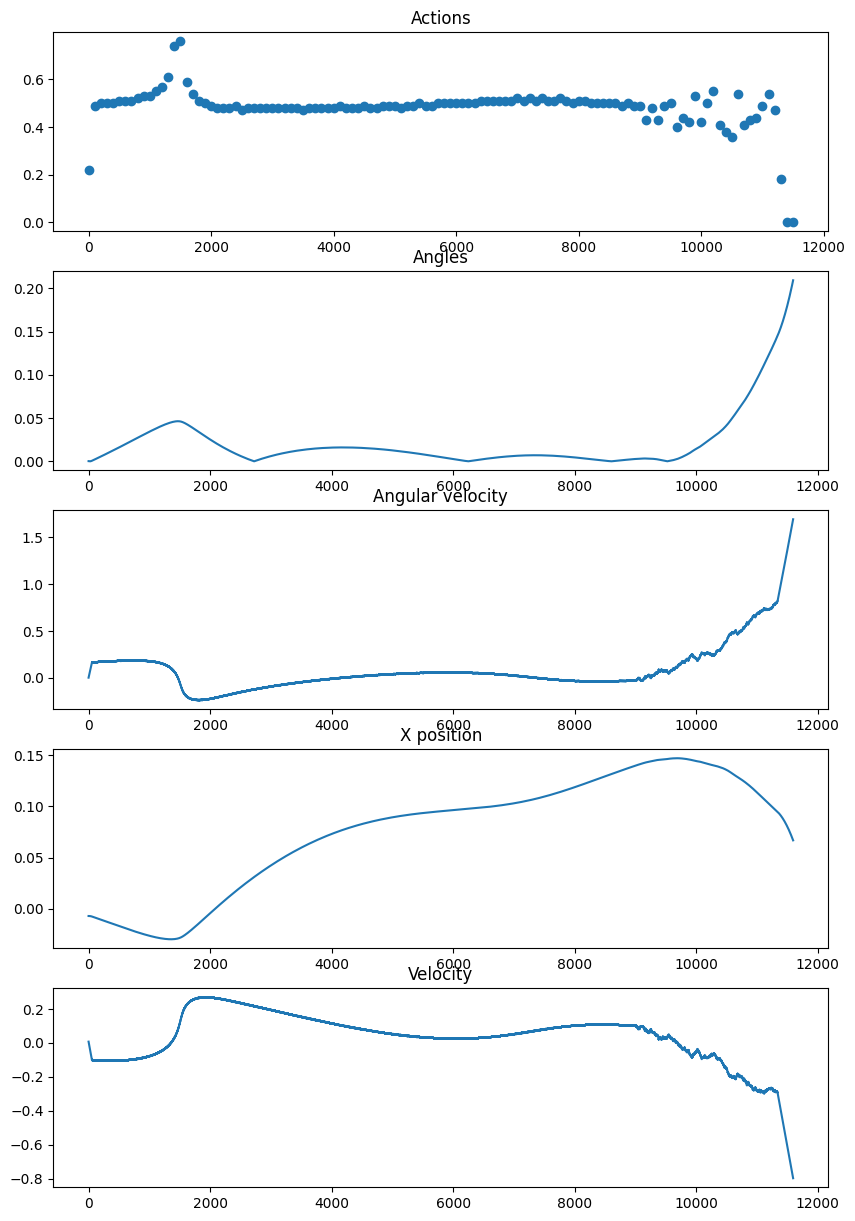

In [67]:
fig, ax = plt.subplots(5, 1, figsize=(10, 15))

# Actions -- bin them:
binsize = 100
binned_actions = []
for i in range(0, len(actions[traj_idx]), binsize):
    binned_actions.append(np.mean(actions[traj_idx][i:i+binsize]))
axs = np.arange(0, len(actions[traj_idx]), step=binsize)

ax[0].plot(axs, binned_actions, linestyle="none", marker="o")
ax[0].set_title("Actions")

# ax[0].plot(np.abs(actions[traj_idx]), linestyle="none", marker="o")
ax[1].plot(np.abs(angles[traj_idx]))
ax[1].set_title("Angles")

ax[2].plot(d_angles[traj_idx])
ax[2].set_title("Angular velocity")

ax[3].plot(xs[traj_idx])
ax[3].set_title("X position")

ax[4].plot(dxs[traj_idx])
ax[4].set_title("Velocity")

# for a in ax:
#     a.set_xlim(1000, 1500)


## Data setup 2: the weights across initial states


In [68]:
seed = 43
run_lib.reset_randomness(seed, env=None)

weights = np.ones((num_trajs,)) / num_trajs
# weights = np.random.random((num_trajs,))
# weights /= np.sum(weights)

print("weights:", weights)
print("sum:", np.sum(weights))

weights: [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
sum: 0.9999999999999999


## Learning

Constants

In [69]:
print("num_runs:", args.num_runs)
print("sample_budget:", args.sample_budget)

num_runs: 30
sample_budget: 1000000


### Ground truth value

In [70]:
true_value = total_rewards @ weights
print("true value:", true_value)

true value: 11351.070000000002


### Learn from samples; with diff samplers

In [71]:
samplers_tried = dict(
    q500=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=500),
    q100=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=100),
    q10=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=10),
    q1=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=1),
    q0=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=0),
    u1=approx_integrators.UniformlySpacedIntegrator(1),
    u50=approx_integrators.UniformlySpacedIntegrator(50),
    u500=approx_integrators.UniformlySpacedIntegrator(500),
    u5000=approx_integrators.UniformlySpacedIntegrator(5000),
)

Since everything other than the start state is deterministic, we can just calculate the approximate integrals for each trajectory with each integrator and store these.

In [72]:
approx_integrals = {}
num_pivots = {}

for sampler_name, sampler in tqdm(samplers_tried.items()):
    print("sampler_name:", sampler_name)
    approx_integrals[sampler_name] = []
    num_pivots[sampler_name] = []
    for idx, reward_seq in enumerate(reward_sequences):
        integral, all_pivots = sampler.integrate(reward_seq)
        approx_integrals[sampler_name].append(integral)
        num_pivots[sampler_name].append(len(all_pivots))
    approx_integrals[sampler_name] = np.array(approx_integrals[sampler_name])
    num_pivots[sampler_name] = np.array(num_pivots[sampler_name])



  0%|          | 0/9 [00:00<?, ?it/s]

sampler_name: q500
sampler_name: q100
sampler_name: q10
sampler_name: q1
sampler_name: q0
sampler_name: u1
sampler_name: u50
sampler_name: u500
sampler_name: u5000


In [73]:
traj_id = 0

print("Sample data for trajectory 0:")
print("* True return:", total_rewards[traj_id])
print("* Approx integrals:")
{k: v[traj_id] for k, v in approx_integrals.items()}


Sample data for trajectory 0:
* True return: 11597.0
* Approx integrals:


{'q500': 11597.0,
 'q100': 11597.0,
 'q10': 11597.0,
 'q1': 11597.0,
 'q0': 11597.0,
 'u1': 11597.0,
 'u50': 11574.0,
 'u500': 11549.0,
 'u5000': 10799.0}

In [74]:
traj_id = 0

{k: v[traj_id] for k, v in num_pivots.items()}


{'q500': 27,
 'q100': 27,
 'q10': 27,
 'q1': 27,
 'q0': 27,
 'u1': 11598,
 'u50': 233,
 'u500': 25,
 'u5000': 4}

Now we just keep sampling the start state and integrate accordingly.

In [75]:

seed = 43

data = value_est.simulate_learning(
        seed, samplers_tried, args.sample_budget, num_runs=args.num_runs,
        start_state_weights=weights,
        approx_integrals=approx_integrals, num_pivots=num_pivots,
        tqdm=tqdm)



  0%|          | 0/9 [00:00<?, ?it/s]

sampler_name: q500
sampler_name: q100
sampler_name: q10
sampler_name: q1
sampler_name: q0
sampler_name: u1
sampler_name: u50
sampler_name: u500
sampler_name: u5000


In [76]:
list(data.values())[0][0].keys()

dict_keys(['values_of_trajs', 'running_v_estimate', 'total_pivots'])

In [77]:
# Verify final means.
for sampler_name, all_runs_data in data.items():
    for run_idx, run_data in enumerate(all_runs_data):
        mean_of_indiv = np.mean(run_data["values_of_trajs"])
        mean_updated = run_data["running_v_estimate"][-1]
        if run_idx == 0:
            print("mean_total:", mean_of_indiv, "mean_updated:", mean_updated)
        if abs(mean_of_indiv - mean_updated) > 0.01:
            assert False, (
                f"Means don't match for {sampler_name}, run {run_idx}: "
                f"{mean_of_indiv} vs {mean_updated}")


mean_total: 11352.618067930234 mean_updated: 11352.618067930283
mean_total: 11350.605216264377 mean_updated: 11350.605216264436
mean_total: 11352.718046330796 mean_updated: 11352.718046330789
mean_total: 11352.103893298774 mean_updated: 11352.103893298856
mean_total: 11352.257843296074 mean_updated: 11352.257843296096
mean_total: 11386.318181818182 mean_updated: 11386.318181818184
mean_total: 11338.9896023766 mean_updated: 11338.989602376601
mean_total: 11221.24144183348 mean_updated: 11221.241441833494
mean_total: 10676.10431 mean_updated: 10676.104309999979


In [78]:
_values_data = plot_utils.process_across_runs(
        data, "total_pivots", "running_v_estimate", right=np.nan)

_means = {
    k: np.abs(val - true_value)
    for k, val in _values_data.means.items()
}
error_data = _values_data._replace(means=_means)

error_y_label = "$|\hat{V}(S_0) - v_\pi(S_0)|$"

/Users/szepi1991/Code/adaptive_time/code/adaptive_time/plot_utils.py:64: RuntimeWarning: Mean of empty slice
  all_y_means[name] = np.nanmean(res, axis=0)
/Users/szepi1991/Code/adaptive_time/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Plotting

In [93]:
setting_name = "step reward" if discrete_reward else "smooth reward"
setting_name += ", "
setting_name += "term if falls" if SHOULD_TERMINATE else "(20k steps)"
print(setting_name)

title = f"setting: {setting_name}"

step reward, term if falls


#### Uniforms

In [94]:
# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "u" in x,
#     add_stderr=True)
# # ax.set_ylim(-5, 30)

# plt.savefig('unif_lin_full.png')


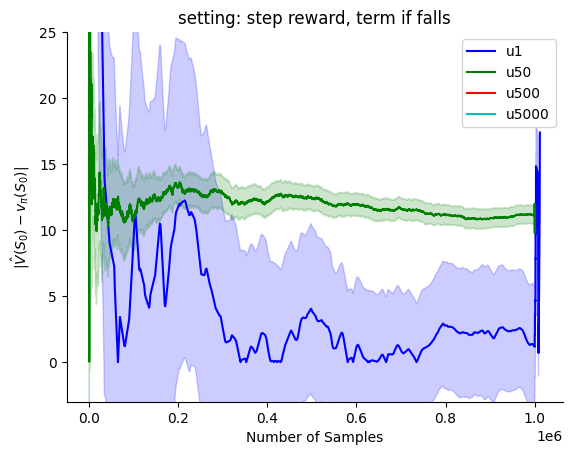

In [95]:
ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", error_y_label,
    title=title, show=False, key_filter=lambda x: "u" in x,
    add_stderr=True)
ax.set_ylim(-3, 25)

plt.savefig('unif_lin_zoom.png')



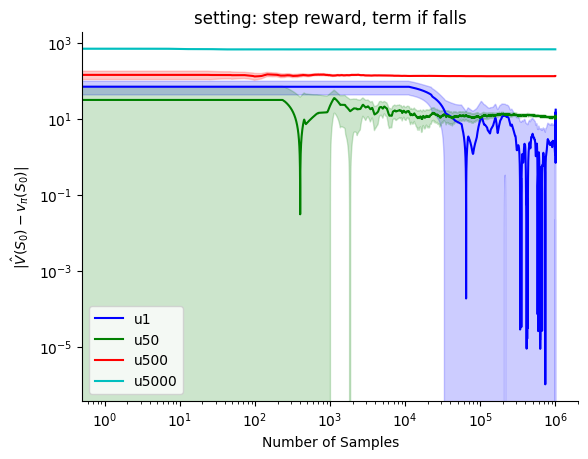

In [96]:
ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", error_y_label,
    title=title, show=False, key_filter=lambda x: "u" in x,
    add_stderr=True)

ax.set_yscale('log')
ax.set_xscale('log')

plt.savefig('unif_loglog.png')



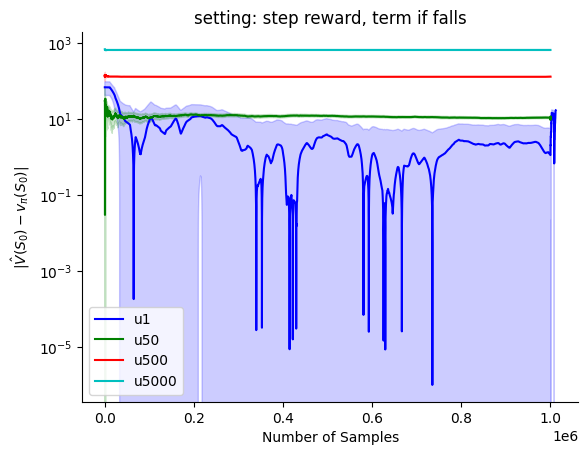

In [97]:
ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", error_y_label,
    title=title, show=False, key_filter=lambda x: "u" in x,
    add_stderr=True)

ax.set_yscale('log')
# ax.set_xscale('log')
plt.savefig('unif_ylog.png')



In [98]:

# ax = plot_utils.default_plot_mean_from_proc_data(
#     error_data, "Number of Samples", error_y_label,
#     title=title, show=False, key_filter=lambda x: "q" in x,
#     add_stderr=True)

# ax.set_ylim(-1, 15)
# # ax.set_yscale('log')

# plt.savefig('quad_lin_zoom.png')

# plt.show()



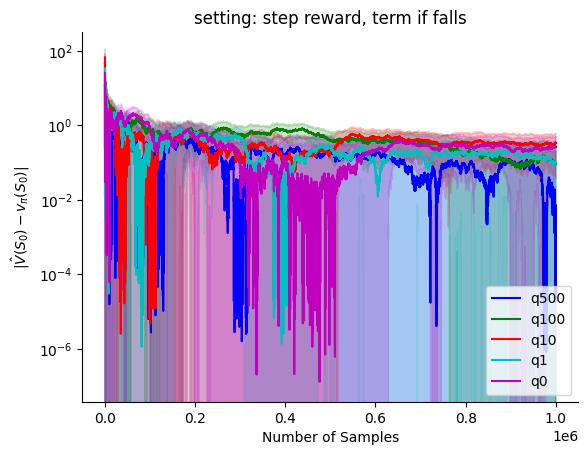

In [99]:

ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", error_y_label,
    title=title, show=False, key_filter=lambda x: "q" in x,
    add_stderr=True)

# ax.set_ylim(-2, 15)
ax.set_yscale('log')

plt.savefig('quad_ylog.png')

plt.show()



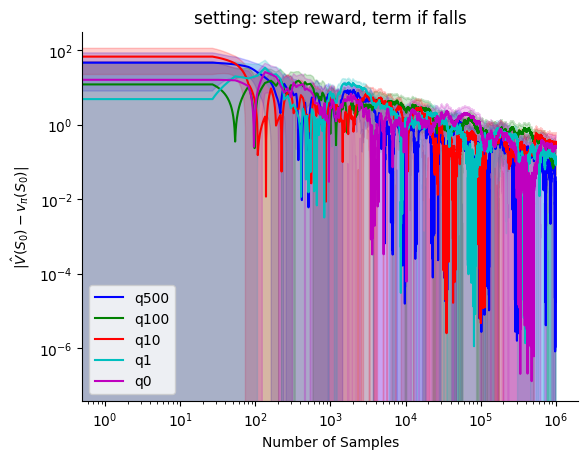

In [100]:

ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", error_y_label,
    title=title, show=False, key_filter=lambda x: "q" in x,
    add_stderr=True)

ax.set_yscale('log')
ax.set_xscale('log')

plt.savefig('quad_loglog.png')

plt.show()



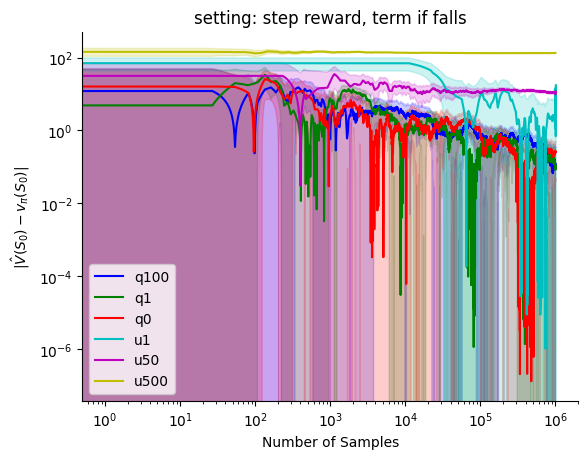

In [103]:
good = ["u1", "u50", "u500", "q0", "q1", "q100"]

ax = plot_utils.default_plot_mean_from_proc_data(
    error_data, "Number of Samples", error_y_label,
    title=title, show=False, key_filter=lambda x: x in good,
    add_stderr=True)

# ax.set_ylim(-2, 40)
ax.set_xscale('log')
ax.set_yscale('log')

plt.savefig('select_loglog.png')

plt.show()



# Testing Random Things

In [102]:
(math.pi + 3.5) % (2*math.pi) - math.pi

-2.7831853071795862